# VAMP / time-lagged CCA

For users already familiar with the VAMP interface: The corresponding [API docs](../api/generated/deeptime.decomposition.VAMP.rst#deeptime.decomposition.VAMP).

VAMP <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite> is short for [V]ariational [A]pproach for [M]arkov [P]rocesses. It can be used as linear dimensionality reduction tool and extends [TICA](tica.ipynb) in the sense that it gives rise to a systematic way to select input features as well as handles off-equilibrium data consistently. The method is a form of canonical correlation analysis <cite data-cite="nbvamp-hotelling1992relations">(Hotelling, 1992)</cite> (originally presented in 1935) in time, also called time-lagged canonical correlation analysis (TCCA).

While the VAMP model possesses methods to project data into lower dimensions, it also is equipped with scoring functions (the so-called VAMP scores), which allow ranking of features. This has been demonstrated in, e.g., <cite data-cite="nbvamp-scherer2019variational">(Scherer, 2019)</cite>.

In order to estimate a VAMP model, a Koopman operator $\mathcal{K}_\tau$ is estimated, which describes conditional future expectation values for a fixed lag time $\tau$. Its action on a function $g$ can be written as

$$ \mathcal{K}_\tau g(x) = \int p(y\mid x)g(y) dy = \mathbb{E}[g(x_{t+\tau} | x_t = x) ],$$

where $p(y \mid x)$ is the conditional probability density that a point $y$ at time $t+\tau$ is visited given that point $x$ was visited at time $t$. Making the ansatz that $g$ is a linear combination $g = \sum_i w_i \chi_i$ for some basis functions $\chi_i$, the linear operator $\mathcal{K}_\tau$ can be expressed as matrix $K$. It can be shown <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite>, that the dominant eigenfunctions of an SVD of the Koopman operator in a whitenend basis $\bar K$ yields the best dynamical model for a given timeseries, which is also what is computed and projected on in estimator and model, respectively.

VAMP deals with off-equilibrium cases consistently, which can be divided into three subcategories (as presented in <cite data-cite="nbvamp-koltai2018optimal">(Koltai, 2018)</cite>):

1. *Time-inhomogeneous dynamics*, e.g, the observed system is driven by a time-dependent external force,
2. *Time-homogeneous non-reversible dynamics*, i.e., detailed balance is not obeyed and the observations might be
   of a non-stationary regime.
3. *Reversible dynamics but non-stationary data*, i.e., the system possesses a stationary distribution with respect
   to which it obeys detailed balance, but the empirical of the available data did not converge to this stationary
   distribution.
   
The third of the described cases is salvageable with TICA when a special reweighting procedure
([Koopman reweighting](tica.ipynb#Koopman-reweighting)) is used.

## Short API demonstration

To create a [VAMP estimator](../api/generated/deeptime.decomposition.VAMP.rst#deeptime.decomposition.VAMP), deeptime needs to be imported...

In [1]:
import deeptime

..., then the estimator can be found in the decomposition subpackage.

In [2]:
vamp_estimator = deeptime.decomposition.VAMP(
    dim=1  # projection dimension
)

One should note that the `dim` parameter can either be `None`, of type `int` or of type `float`:

- if `None`, all dimensions are kept,
- if of type `int` (and `>= 1`), this is the dimension to project onto,
- and if of type `float` (in the range $(0, 1]$), then this is interpreted as a percentage value which is the minimum threshold of kinetic variance that needs to be explained by the projection.

> Note that unless `None`, even setting the dimension with an integer might yield a lower-dimensional projection than the one requested if there is a rank deficit in the covariance matrices.

For demonstration purposes, we look at the Ellipsoids sample dataset, which is described in some detail in the example data's [documentation](../api/generated/impl/deeptime.data.ellipsoids_dataset.Ellipsoids.rst#deeptime.data.ellipsoids_dataset.Ellipsoids). In short, it is a two-dimensional process that has two metastable states in the form of nonoverlapping ellipsoids.

In [3]:
# create dataset instance with fixed seed for reproducibility
ellipsoids = deeptime.data.ellipsoids(seed=17)
# 1000 observations
feature_trajectory = ellipsoids.observations(1000)
print(feature_trajectory.shape)

(1000, 2)


Given the data, all that is left to do is to fit a model by providing covariances and obtaining it from the estimator or using `fit` on the timeseries directly. In the latter case, a lagtime must be provided.

In [4]:
covars = deeptime.decomposition.VAMP.covariance_estimator(
    lagtime=1  # the time lag with which the covariance matrices are estimated
).fit(feature_trajectory).fetch_model()
vamp_estimator.fit(covars)
model = vamp_estimator.fetch_model()

# ---- or ----

model = deeptime.decomposition.VAMP(lagtime=1, dim=1).fit(feature_trajectory).fetch_model()

The output dimension is set to `1`:

In [5]:
model.output_dimension

1

And the model can be scored, which evaluates how much "slowness" is captured with the current input features. Scores can **not** be compared across different lagtimes $\tau$.

In [7]:
model.score(r=2)

1.8534787431760964

Projecting the 2-dimensional data with the estimated VAMP model yields a 1-dimensional trajectory which clearly reveals the two-state metastable process which generated the data:

Projection shape: (1000, 1)



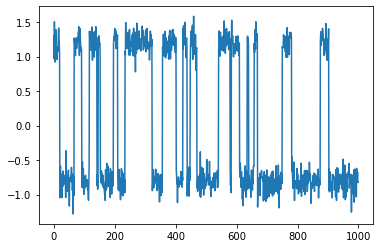

In [8]:
projection = model.transform(feature_trajectory)
print(f"Projection shape: {projection.shape}\n")

# plot projection
import matplotlib.pyplot as plt
plt.plot(projection);

## A more detailed look on the estimator

Here we follow the content presented in <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite> to give some more insight into the estimator. For a complete derivation and background please consult the source itself.

The VAMP estimator estimates a _linear_ model of the form

$$ \mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)], $$

where $\tau > 0$ is the lagtime, $f(x) = (f_1(x),\ldots)^\top$ and $g(x) = (g_1(x),\ldots)^\top$ are feature transformations of the system's state $x$ at a point in time $t$ so that the dynamics are approximately linear.

While the matrix $K$ can in principle also be estimated using standard regression tools, the regression error gives no information about the choice of feature trasformations $f$ and $g$. When estimating $K$ using VAMP, a meaningful scoring and thus cross-validation is available. For details on the available scores, see the [Scoring](#Scoring) section.

This matrix is actually a finite-dimensional approximation of the Koopman operator

$$ \mathcal{K}_\tau f(x) = \mathbb{E}[f(x_{t+\tau} | x_t = x) ], $$

which maps for given $x_t$ observed through $f$ to the expected value of an arbitrary observable $g$ at time $t+\tau$. This in particular means that the matrix $K$ depends on $\mathcal{K}_\tau$, i.e., models at different lagtimes approximate different operators and are thus not directly comparable.

One can show (Theorem 1 of <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite>), that the best approximation of $K$ to $\mathcal{K}_\tau$ is achieved for

$$ \bar K=\mathrm{diag}(\sigma_1,\ldots,\sigma_k), $$

when $f = (\psi_1,\ldots,\psi_k)$ and $g=(\phi_1,\ldots,\phi_k)$. Here $\sigma_i$, $\psi_i$, $\phi_i$ are the singular values, left singular functions, and right singular functions of $\mathcal{K}_\tau^*\mathcal{K}_\tau$, respectively. The operator $\mathcal{K}_\tau^*\mathcal{K}_\tau$ relates to a foward-backward mapping in time. The $\psi_i$ and $\phi_i$ should form an orthonormal basis of respective spaces. In particular this means that in this representation,

$$ \mathbb{E}[\phi_i(x_{t+\tau})] = \sigma_i\mathbb{E}[\psi_i(x_t)] \text{ and } \bar{\mathcal{K}}_\tau f = \sum_i \sigma_i \langle f, \phi_i \rangle_{\rho_1} \psi_i, $$

where $\bar{\mathcal{K}}_\tau$ denotes the projected Koopman operator.

The [VAMP estimator](../api/generated/deeptime.decomposition.VAMP.rst#deeptime.decomposition.VAMP) first and foremost solves the following problem:

> Given a basis set $\chi^\top = (\chi_0, \chi_1)^\top$ so that $f = U^\top \chi_0$ and $g=V^\top \chi_1$, find weights $U,V\in\mathbb{R}^{m\times k}$ so that the resulting linear model $\mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)]$ is optimal. For the purposes of estimation the potentially different basis sets $\chi_0$ and $\chi_1$ are assumed to be equal. In practice one can achieve this by simply concatenating the observable trajectories in time.

When there are significantly more frames than dimensions in the dataset, the (instantaneous and time-lagged) mean-free covariance matrices $C_{00}, C_{0t}, C_{tt}$ with

$$\begin{aligned}
C_{00} &= \mathbb{E}_t[(\chi_0(x_t)-\mu_0)(\chi_0(x_t)-\mu_0)^\top], \\
C_{0t} &= \mathbb{E}_t[(\chi_0(x_t)-\mu_0)(\chi_1(x_{t+\tau})-\mu_1)^\top],\\
C_{tt} &= \mathbb{E}_t[(\chi_1(x_{t+\tau})-\mu_1)(\chi_1(x_{t+\tau})-\mu_1)^\top]
\end{aligned}$$

can be computed by the [Covariances estimator](../api/generated/deeptime.covariance.Covariance.rst#deeptime.covariance.Covariance). These covariance matrices can be accessed in the computed model:

In [9]:
print("mean_0 shape:", model.mean_0.shape)
print("mean_t shape:", model.mean_t.shape)
print("C00 shape:", model.cov_00.shape)
print("C0t shape:", model.cov_0t.shape)
print("Ctt shape:", model.cov_tt.shape)

mean_0 shape: (2,)
mean_t shape: (2,)
C00 shape: (2, 2)
C0t shape: (2, 2)
Ctt shape: (2, 2)


Based on these covariances, the truncated SVD

$$\bar K = C_{00}^{-1/2}C_{0t}C_{tt}^{-1/2} \approx U' \mathrm{diag}(\sigma_1,\ldots,\sigma_k) V'^\top $$

is evaluated, where $\bar K$ is the Koopman matrix for normalized basis functions $C_{00}^{-1/2}\chi_0$ and $C_{tt}^{-1/2}\chi_1$, respectively. The truncation is based on the [dim](../api/generated/deeptime.decomposition.VAMP.rst#deeptime.decomposition.VAMP.dim) parameter of the estimator.

The sought-after weight matrices $U$ and $V$ are then given by

$$\begin{aligned}
U &= C_{00}^{-1/2}U', \\
V &= C_{tt}^{-1/2}V',
\end{aligned}$$

respectively. The singular values as well as $U$ and $V$ are accessible as:

In [10]:
print("singular values:", model.singular_values)
print("left singular vectors U:", model.singular_vectors_left)
print("right singular vectors V:", model.singular_vectors_right)

singular values: [0.92383913 0.02905651]
left singular vectors U: [[-0.39412183]
 [ 0.40228095]]
right singular vectors V: [[-0.40095045]
 [ 0.40235857]]


The resulting linear model 

$$ \mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)] $$

is then given by $K = \mathrm{diag}(\sigma_1,\ldots,\sigma_k)$, $f_i = u_i^\top\chi_0$, and $g_i = v_i^\top\chi_1$.

The model's [transform(data, forward=True)](../api/generated/deeptime.decomposition.CovarianceKoopmanModel.rst#deeptime.decomposition.CovarianceKoopmanModel.transform) gives access to $f$ and $g$:

In [12]:
x = model.transform(feature_trajectory, propagate=False)

In [13]:
model.singular_values

array([0.92383913, 0.02905651])

In [14]:
model.output_dimension

1

In [15]:
x.shape

(1000, 1)

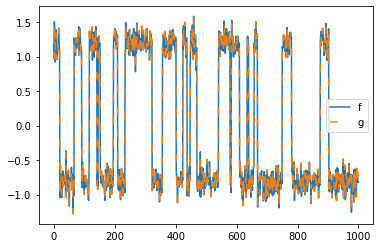

In [17]:
plt.plot(model.transform(feature_trajectory, instantaneous=True), label="f")
plt.plot(model.transform(feature_trajectory, instantaneous=True), linestyle=(0, (5, 10)), label="g")
plt.legend();

As one can observe, it makes no difference whether one projects $x_t \mapsto f(x_t)$ (forward in time) or $x_t\mapsto g(x_t)$ (backward in time). This is because the underlying process is time-reversible.

A consequence of this is that one should be aware of which data is provided into `transform`: Only 

- `feature_trajectory[:-tau, ...]` for `f` (i.e., `right=False`) and
- `feature_trajectory[tau:, ...]` for `g` (i.e., `right=True`)

contain valid values, the remainder might be interpreted as extrapolation.

## Scoring

While the estimator solves the problem of finding optimal transforms $f$, $g$, and $K$, one of the advantages of using the variational approach is that the models can be scored with respect to the choice of the system's featurization.

This makes it possible to not only optimize for transforms given a basis but also for the basis itself. If -hyothetically- infinite data and computational power were avaiable, the best possible basis would be the one that can describe the full operator $\mathcal{K}_\tau$. In practice however, often a balance between the modeling/discretization error of approximating $\mathcal{K}_\tau$ and the statistical error of fitting the parameters given finite data has to be struck.

There are three different scores implemented in deeptime:

1. The VAMP-1 score, evaluating the sum of the singular values $s = \sum_i\sigma_i$ <cite data-cite="nbvamp-noe2013variational">(Noé, 2013)</cite> and <cite data-cite="nbvamp-mcgibbon2015variational">(McGibbon, 2015)</cite>:

In [18]:
model.score(r=1)

1.9238391327369158

2. The VAMP-2 score, evaluating the squared sum of the singular values $s = \sum_i \sigma_i^2$, which maximizes the kinetic variance captured by the model <cite data-cite="nbvamp-noe2015kinetic">(Noé, 2015)</cite>. It is also directly related to the approximation error to the true Koopman operator $\mathcal{K}_\tau$ <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite>. This is the default choice for scoring.

In [19]:
model.score(r=2)

1.8534787431760964

3. The VAMP-E score also relates to the approximation error to the true Koopman operator, however its computation is numerically more stable than VAMP-1 or VAMP-2, as it does not involve any matrix inversions <cite data-cite="nbvamp-wu2020variational">(Wu, 2020)</cite>.

In [20]:
model.score(r="E")

1.8534787431760968

In addition to the `score_method` parameter, there is also a `test_model` parameter. By default it is `None` and the score is evaluated as-is. In case it is not `None`, the `score()` method evaluates the cross-validation score between the current model and `test_model`.

> It is assumed that the model and the test_model stem from respective "training" and "testing" datasets. Estimation of the average cross-validation score and partitioning of data into test and training part is not performed by this method.

## Singular vector scaling

Optionally the singular vectors can be scaled upon projection. Per default, [scaling](../api/generated/deeptime.decomposition.VAMP.rst#deeptime.decomposition.VAMP.scaling) is set to `None` which means that no scaling is applied and the variance of all singular vectors (sometimes also called order parameters) is $1$.

In [21]:
print(vamp_estimator.scaling)

None


One has the option to set it to `"kinetic_map"`, which means that the singular vectors are scaled by their respective singular value. As a result, Euclidean distances in the "left singular vectors"-transformed data approximate kinetic distances with respect to the forward propagator. Vice versa, a kinetic map is induced when using scaled right singular vectors and the backward propagator.

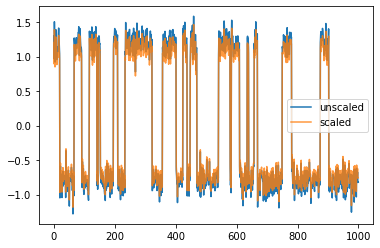

In [23]:
vamp_estimator.scaling = "kinetic_map"
scaled_model = vamp_estimator.fit(covars).fetch_model()

# plotting transformations
plt.plot(model.transform(feature_trajectory), label="unscaled")
plt.plot(scaled_model.transform(feature_trajectory), alpha=.8, label="scaled")
plt.legend();

## Example with position based fluids

Here we demonstrate a toy dataset created by a position based fluids (PBF) simulator <cite data-cite="nbvamp-macklin2013position">(Macklin, 2013)</cite>. In a 2-dimensional simulation box we place particles which then relax to a resting density. We periodically disturb the equilibrium resting density by applying a force toward the left and right boundary of the simulation box alternatingly. For more details on the dataset, please refer to the example data's [documentation](../api/generated/deeptime.data.position_based_fluids.rst#deeptime.data.position_based_fluids).

Here, we create a new PBF simulator with a predefined simulation box and set of initial positions:

In [24]:
pbf_simulator = deeptime.data.position_based_fluids(n_jobs=8)

It contains

In [25]:
pbf_simulator.n_particles

972

particles, which are equilibrated for 5000 simulation steps.

Now, we generate a trajectory with an oscillatory force acted upon the particles. Each oscillation round contains two sets of the force applied toward the left simulation box border and right simulation box border, respectively for 400 steps each.

In [26]:
trajectory = pbf_simulator.simulate_oscillatory_force(n_oscillations=7, n_steps=400)

We visualize the trajectory with a matplotlib animation under a stride of 30:

In [27]:
animation = pbf_simulator.make_animation(trajectory, stride=30, mode="scatter", figsize=(5, 4))
from IPython.display import HTML
HTML(animation.to_html5_video())

Since the trajectory just contains the x-y coordinates of the particles, it is in $\mathbb{R}^{T \times 2\cdot \mathrm{n\_particles}}$.

In [28]:
print(trajectory.shape)

(5600, 1944)


For the purpose of estimating a VAMP model on this trajectory and analyzing the slow motions, the trajectory is featurized using a Gaussian KDE:

In [29]:
n_grid_x = 20
n_grid_y = 10
kde_trajectory = pbf_simulator.transform_to_density(
    trajectory, n_grid_x=n_grid_x, n_grid_y=n_grid_y, n_jobs=8
)

This featurized trajectory can be visualized similarly:

In [30]:
animation = pbf_simulator.make_animation(kde_trajectory, stride=30, mode="contourf", 
                                         n_grid_x=n_grid_x, n_grid_y=n_grid_y, figsize=(5, 4))
HTML(animation.to_html5_video())

A VAMP model can be estimated like below.

In [31]:
model = deeptime.decomposition.VAMP(lagtime=100).fit(kde_trajectory).fetch_model()

Afterwards, we can project with the left and right eigenfunctions

In [32]:
projection_left = model.transform(kde_trajectory, instantaneous=True)
projection_right = model.transform(kde_trajectory, instantaneous=False)

And visualize also these.

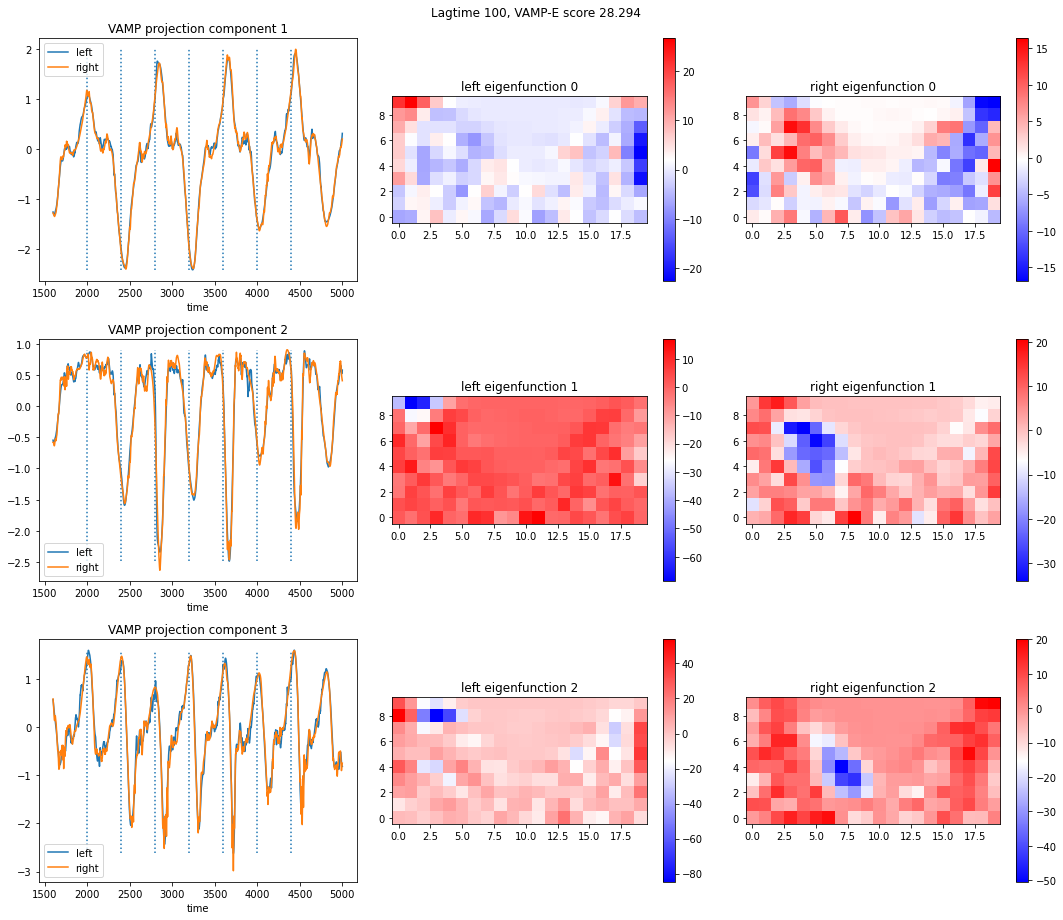

In [35]:
import numpy as np

tau = model.cov.lagtime
n_sing = 3

f, axes = plt.subplots(ncols=3, nrows=n_sing, figsize=(n_sing*5, 13))
f.suptitle("Lagtime {}, VAMP-E score {:.3f}".format(tau, model.score("E")))
for i in range(n_sing):
    left = projection_left[:-tau][1600:5000, i]
    right = projection_right[tau:][1600:5000, i]
    axes[i][0].plot(np.arange(1600, 5000), left, label="left")
    axes[i][0].plot(np.arange(1600, 5000), right, label="right")
    axes[i][0].vlines([1600 + i*400 for i in range(1,8)], 
                      np.min(left), np.max(right), linestyles='dotted')
    axes[i][0].set_title(f"VAMP projection component {i+1}")
    axes[i][0].set_xlabel("time")
    axes[i][0].legend()

    ax = axes[i][1]
    im = model.singular_vectors_left[:, i].reshape((n_grid_y, n_grid_x))
    cb = ax.imshow(im, origin="lower", cmap="bwr")
    f.colorbar(cb, ax=ax)
    ax.set_title("left eigenfunction {}".format(i))

    ax = axes[i][2]
    im = model.singular_vectors_right[:, i].reshape((n_grid_y, n_grid_x))
    cb = ax.imshow(im, origin="lower", cmap="bwr")
    f.colorbar(cb, ax=ax)
    ax.set_title("right eigenfunction {}".format(i))
plt.tight_layout()
plt.show();

The dotted vertical lines are whenever the force changes direction. When looking at the intensity of the left and right eigenfunctions, areas that are of similar intensity in left as well as right can be considered "coherent".

Further, left and right eigenfunction projections are same, which means that the process is reversible. In such a case the magnitude of the singular values should decay exponentially and one can look for a so-called spectral gap.

Text(0, 0.5, 'magnitude')

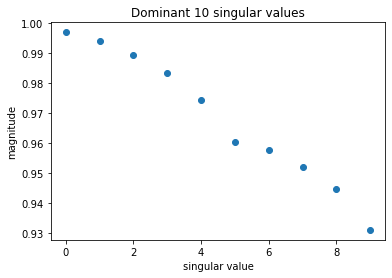

In [36]:
plt.plot(model.singular_values[:10], 'o')
plt.title("Dominant 10 singular values");
plt.xlabel("singular value")
plt.ylabel("magnitude")

From the estimated linear model

$$ \mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)] $$

we can also apply the forward operator to frames by calling [forward()](../api/generated/deeptime.decomposition.CovarianceKoopmanModel.rst#deeptime.decomposition.CovarianceKoopmanModel.forward). It also allows to project onto specific processes by setting all other singular values to zero.

In [37]:
forward_full = model.forward(kde_trajectory)

Here we show the result of the forward operation, i.e., propagating the left-hand side to its future (with $\tau=100$) expected value.

In [38]:
animation = pbf_simulator.make_animation([kde_trajectory, forward_full], stride=30, mode="contourf", 
                                         n_grid_x=n_grid_x, n_grid_y=n_grid_y, figsize=(10, 4))
HTML(animation.to_html5_video())

What becomes clearer in the projection onto single processes is that

- the slowest process is associated with a density change from left <-> right
- the second slowest process is associated with a density change middle <-> sides

This can also be seen in the plot of the 1-dimensional projection onto a specific component of the whitened space in above plot:

> For the slowest process (component 0) there is a sign change roughly every 800 frames, for the second slowest process (component 1) it is roughly every 400 frames. The combination of the four dominant components shows some notion of a flow from left to right and vice versa and is therefore already quite close to the trajectory except for particle splashes.

In [39]:
forward_component0 = model.forward(kde_trajectory, components=0)
forward_component1 = model.forward(kde_trajectory, components=1)
forward_component0123 = model.forward(kde_trajectory, components=[0, 1, 2, 3])

In [40]:
animation = pbf_simulator.make_animation(
    [kde_trajectory, forward_component0, 
     forward_component1, forward_component0123
    ], stride=30, mode="contourf", n_grid_x=n_grid_x, n_grid_y=n_grid_y, nrows=2, ncols=2, 
    figsize=(10, 8), titles=["trajectory", "component 0", "component 1", 
                             "dominant components 0, 1, 2, 3"])
HTML(animation.to_html5_video())